In [1]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

Here we create the test_model function that takes inputs the hyperparmaters of the model and runs the model

In [8]:
def test_model(episodes_num, runs_num, architecture, learning_rate, memory_size, batch_size, epsilon, update_net_freq):


    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(runs_num):
        print(f"Starting run {run+1} of {runs_num}")
        policy_net = DQN(architecture)
        target_net = DQN(architecture)
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
        memory = ReplayBuffer(memory_size)

        steps_done = 0

        episode_durations = []
        for i_episode in range(episodes_num):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", episodes_num)

            observation, info = env.reset()
            state = torch.tensor(observation).float()


            done = False
            terminated = False
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_net_freq == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results

Find optimal architecture given a fixed epsilon=0.35, memory_size=20000, batch_size=1000, learning_rate=0.01, update_net_freq=1

In [13]:
architectures = [[4,4,16,2], [4,16,16,2], [4,16,32,2],[4,32,32,2],[4,32,64,2],[4,64,64,2]]

#SAVE THIS VARIABLE USING PICKLE
architecture_results = []

for architecture in architectures:
    architecture_results.append(test_model(episodes_num=300, runs_num=10, architecture=architecture, learning_rate=0.01, memory_size=20000, batch_size=1000, epsilon=0.35, update_net_freq=1))



Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

Access results of archtecture tuning

In [2]:
import pickle 

file_name = "architecture_parameter.pkl"

with open(file_name, "rb") as file:
    loaded_variables = pickle.load(file)

architecture_results = loaded_variables["architecture_results"]
architectures = [[4,4,16,2], [4,16,16,2], [4,16,32,2],[4,32,32,2],[4,32,64,2],[4,64,64,2]]

Plot of average mean return with varying architecture + best architecture detected

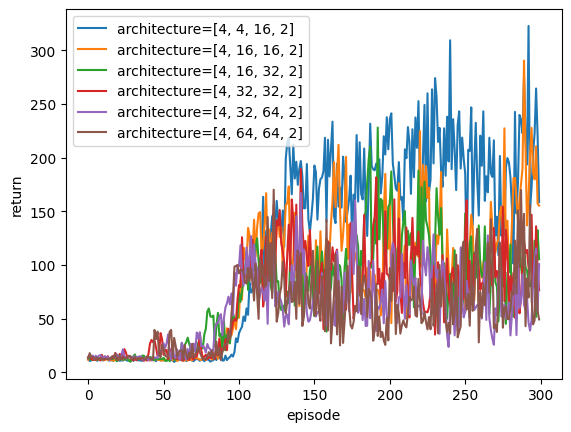

[[4, 4, 16, 2]]

In [3]:
legends = []
max_val = -float("inf")
best_architecture_results = None
best_architecture = None
consitently_above_100 = []
for idx, architecture in enumerate(architecture_results):
    results = torch.tensor(architecture)
    means = results.float().mean(0)
    if torch.mean(means[200:]) > max_val:
        best_architecture_results = architecture
        max_val = torch.mean(means[200:])
        best_architecture = architectures[idx]
    if (means[200:] > 95).all():
        consitently_above_100.append(architectures[idx])
    legend = f"architecture={architectures[idx]}"
    legends.append(legend)
    plt.plot(torch.arange(300), means)

plt.legend(legends)
plt.ylabel("return")
plt.xlabel("episode")
plt.show()
consitently_above_100

Save the results

In [5]:
import pickle

file_name = "architecture_parameter.pkl"

variables = {"best_architecture" : best_architecture, "best_architecture_results" : best_architecture_results, "architecture_results" : architecture_results}

with open(file_name, "wb") as file:
    pickle.dump(variables, file)

Find optimal (memory_size, batch_size) pair given fixed espilon=0.32, architecture=best_architecture, learning_rate=0.01, update_net_freq=1

In [6]:
memory_sizes = [1000, 5000, 10000, 15000, 20000, 30000]
batch_sizes = [[0.01, 0.03, 0.05]] * len(memory_sizes)


#SAVE THIS VARIABLE USING PICKLE
memory_batch_size_results = []

for idx, memory_size in enumerate(memory_sizes):
    for i in range(3):
        batch_size = int(batch_sizes[idx][i] * memory_size)
        memory_batch_size_results.append(test_model(episodes_num=300, runs_num=10, architecture=best_architecture, learning_rate=0.01, memory_size=memory_size, batch_size=batch_size, epsilon=0.35, update_net_freq=1))
        


Starting run 1 of 10


c:\Users\Kotsi\Desktop\AI_Imperial\RL\CW_2\my_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episod

Here we save the results of memory & batch size tuning

In [7]:
import pickle

file_name = "memory_batch_size_parameter.pkl"

variables = {"memory_batch_size_results" : memory_batch_size_results}

with open(file_name, "wb") as file:
    pickle.dump(variables, file)

Plot of average mean return with varying memory and batch size pair + best values detected

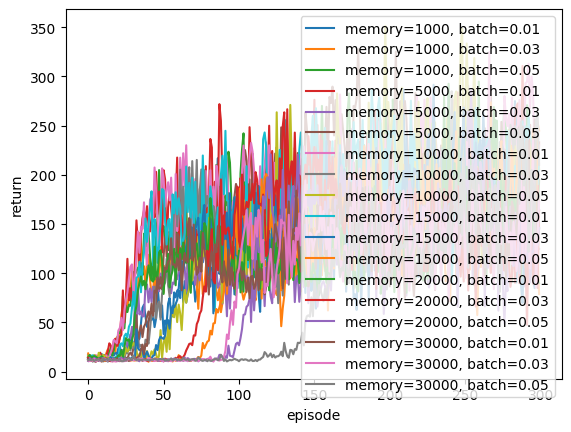

[10000, 0.01]

In [39]:
legends = []
max_val = -float("inf")
best_memory_batch_size_results = None
best_memory_batch_size = None
best_memory_batch_size_results = None
for idx, experiment in enumerate(memory_batch_size_results):
    results = torch.tensor(experiment)
    means = results.float().mean(0)
    if torch.mean(means[200:]) > max_val:
        best_memory_batch_size_results = experiment
        max_val = torch.mean(means[200:])
        best_memory_batch_size_results = experiment
        best_memory_batch_size = [memory_sizes[idx // 3], batch_sizes[idx // 3][idx % 3]]
    legend = f"memory={memory_sizes[idx // 3]}, batch={batch_sizes[idx // 3][idx % 3]}"
    legends.append(legend)
    plt.plot(torch.arange(300), means)

plt.legend(legends)
plt.ylabel("return")
plt.xlabel("episode")
plt.show()
best_memory_batch_size

Access Results of memory_batch_size tuning

In [4]:
import pickle 

file_name = "memory_batch_size_parameter.pkl"

with open(file_name, "rb") as file:
    loaded_variables = pickle.load(file)

memory_batch_size_results = loaded_variables["memory_batch_size_results"]
memory_sizes = [1000, 5000, 10000, 15000, 20000, 30000]
batch_sizes = [[0.01, 0.03, 0.05]] * len(memory_sizes)

See plots of each different memory size

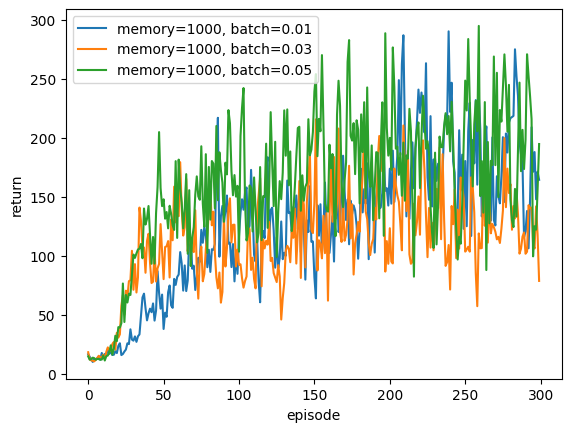

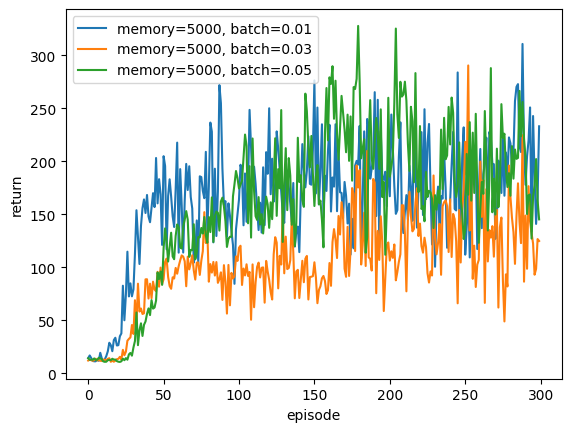

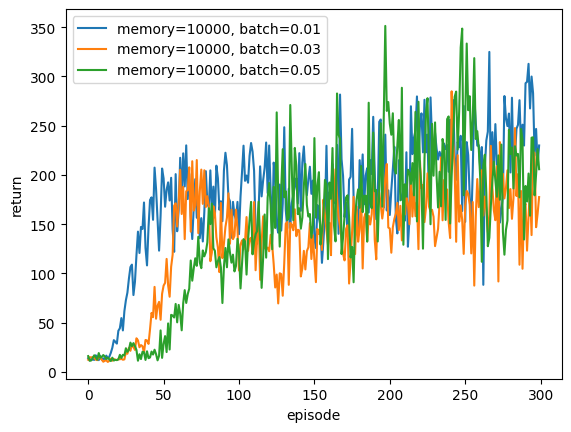

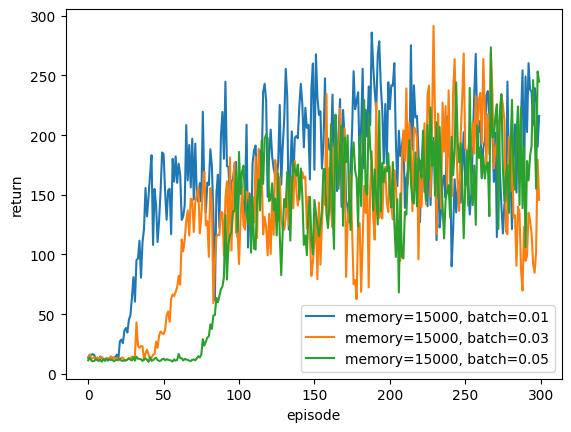

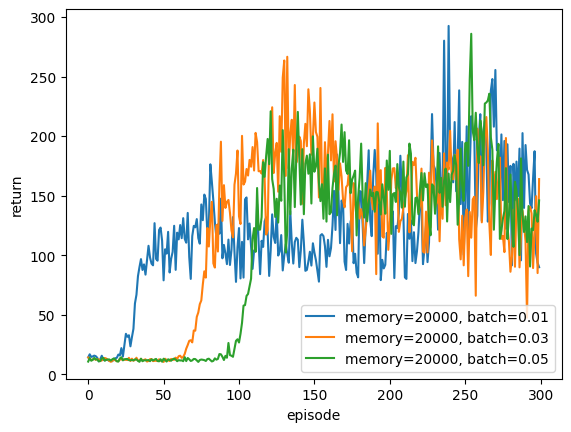

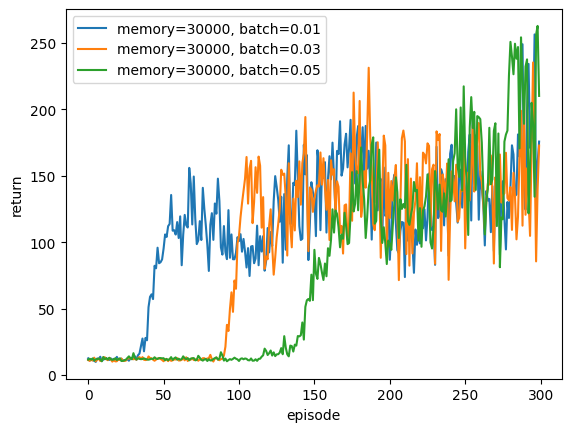

[[1000, 0.01], [5000, 0.01], [5000, 0.05], [10000, 0.05]]

In [73]:
legends = []
max_val = -float("inf")
best_memory_batch_size_results = None
best_memory_batch_size = None
best_memory_batch_size_results = None
consitently_above_100 = []
for idx, experiment in enumerate(memory_batch_size_results):
    results = torch.tensor(experiment)
    means = results.float().mean(0)
    if torch.mean(means[200:]) > max_val:
        best_memory_batch_size_results = experiment
        max_val = torch.mean(means[200:])
        best_memory_batch_size_results = experiment
        best_memory_batch_size = [memory_sizes[idx // 3], batch_sizes[idx // 3][idx % 3]]
    if (means[200:] > 100).all():
        consitently_above_100.append([memory_sizes[idx // 3], batch_sizes[idx // 3][idx % 3]])
    legend = f"memory={memory_sizes[idx // 3]}, batch={batch_sizes[idx // 3][idx % 3]}"
    legends.append(legend)
    plt.plot(torch.arange(300), means)

    if (idx+1) % 3 == 0:
        plt.legend(legends)
        plt.ylabel("return")
        plt.xlabel("episode")
        plt.show()
        legends = []


best_memory_batch_size
consitently_above_100

Find the parameters that result to the lowest std after 150th episode

In [70]:
legends = []
min_val = float("inf")
best_memory_batch_size_results = None
best_memory_batch_size = None
best_memory_batch_size_results = None
consitently_above_100 = []
for idx, experiment in enumerate(memory_batch_size_results):
    results = torch.tensor(experiment)
    stds = results.float().std(0)
    if torch.mean(stds[150:300]) < min_val:
        best_memory_batch_size_results = experiment
        min_val = torch.mean(stds[200:])
        best_memory_batch_size_results = experiment
        best_memory_batch_size = [memory_sizes[idx // 3], batch_sizes[idx // 3][idx % 3]]

best_memory_batch_size

[20000, 0.05]

Check individual plots to compare memory & batch size parameters

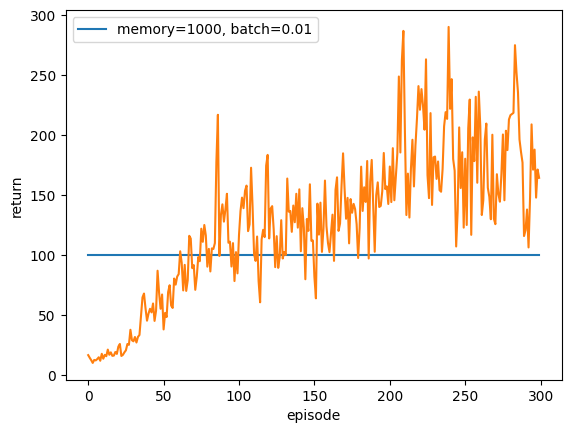

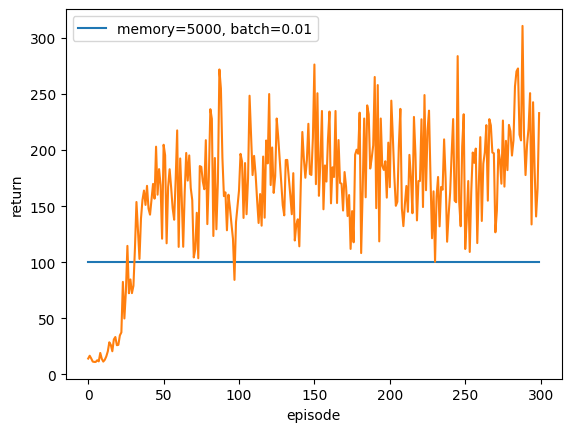

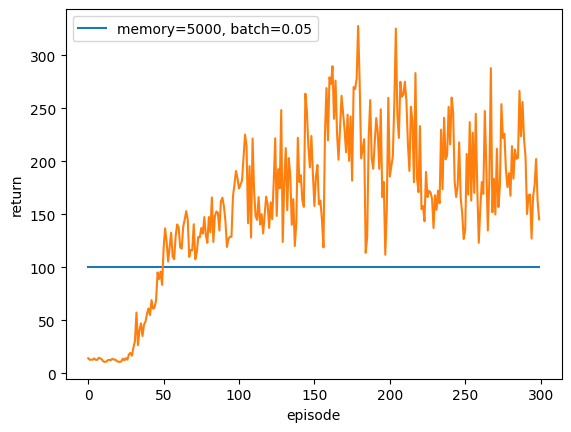

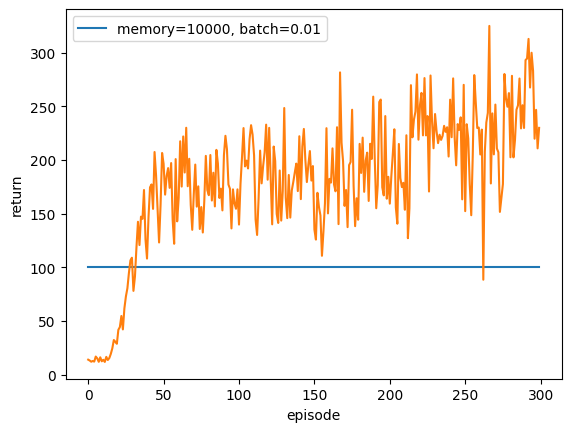

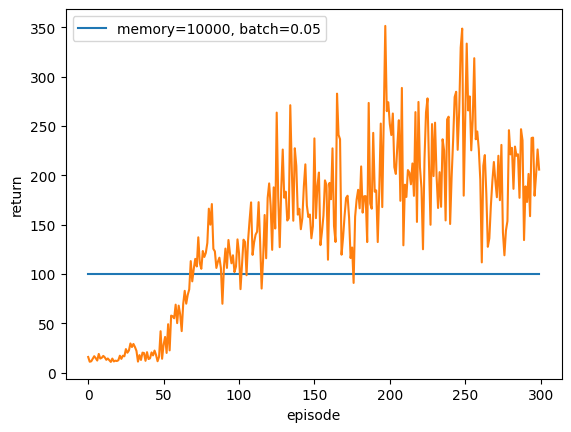

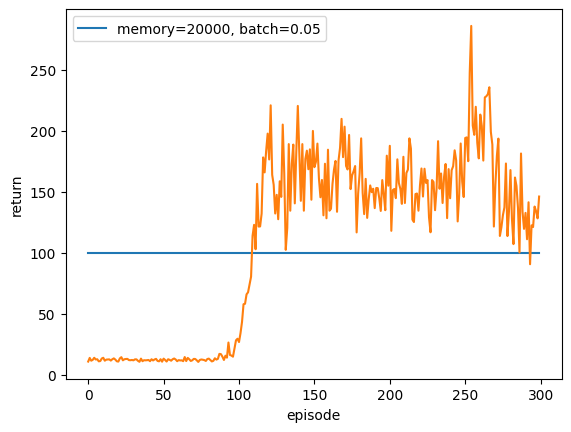

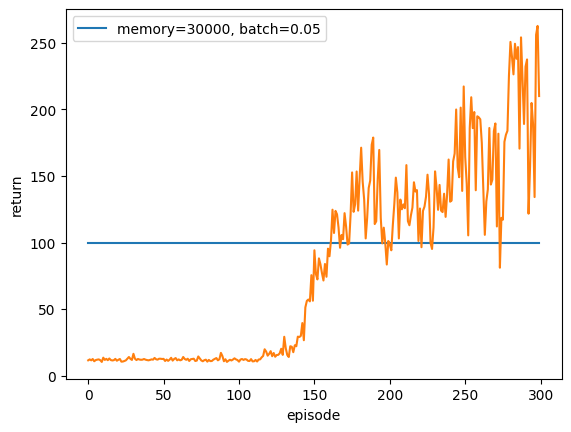

In [75]:
legends = []
for idx, experiment in enumerate(memory_batch_size_results):
    if idx in [0, 3, 5, 6, 8, 14, 17]:
        results = torch.tensor(experiment)
        means = results.float().mean(0)
        legend = f"memory={memory_sizes[idx // 3]}, batch={batch_sizes[idx // 3][idx % 3]}"
        legends.append(legend)
        constant = [100] * 300
        plt.plot(torch.arange(300), constant)
        plt.plot(torch.arange(300), means)


        plt.legend(legends)
        plt.ylabel("return")
        plt.xlabel("episode")
        plt.show()
        legends = []

Change test_model function to tune epsilon, first without a converging epsilon

In [19]:
def test_model_non_decay(episodes_num, runs_num, architecture, learning_rate, memory_size, batch_size, num, update_net_freq):


    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(runs_num):
        print(f"Starting run {run+1} of {runs_num}")
        policy_net = DQN(architecture)
        target_net = DQN(architecture)
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
        memory = ReplayBuffer(memory_size)

        steps_done = 0

        episode_durations = []
        epsilon = 1 + (0.9 / num)
        for i_episode in range(episodes_num):
            if i_episode >= num:
                epsilon = 0.1
            else:
                epsilon -= (0.9 / num)
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", episodes_num)

            observation, info = env.reset()
            state = torch.tensor(observation).float()


            done = False
            terminated = False
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_net_freq == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results

In [20]:
nums= [5, 10, 25, 50, 100, 150]


#SAVE THIS VARIABLE USING PICKLE
nums_results = []

for idx, num in enumerate(nums):
    nums_results.append(test_model_non_decay(episodes_num=300, runs_num=2, architecture=best_architecture, learning_rate=0.01, memory_size=10000, batch_size=100, num=num, update_net_freq=1))
        

Starting run 1 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 2
episode  50 / 300
epis

In [21]:
import pickle

file_name = "non_decay_epsilon_corrected.pkl"

variables = {"non_decay_epsilon_corrected" : nums_results}

with open(file_name, "wb") as file:
    pickle.dump(variables, file)

In [8]:
import pickle 

file_name = "non_decay_epsilon_corrected_2.pkl"

with open(file_name, "rb") as file:
    loaded_variables = pickle.load(file)

nums_results = loaded_variables["non_decay_epsilon_corrected_2"]
nums= [5, 10, 25, 50, 100, 150]

Plots of results for varying not converging epsilon

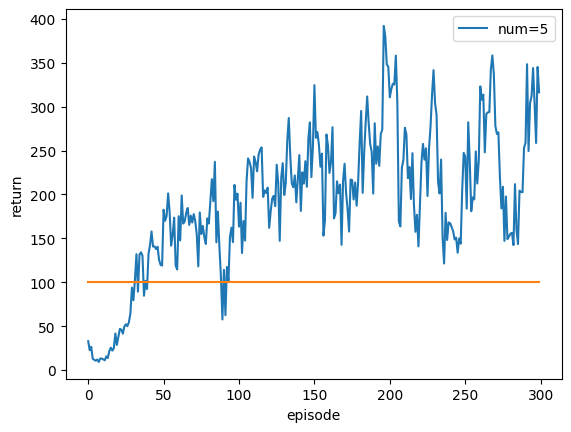

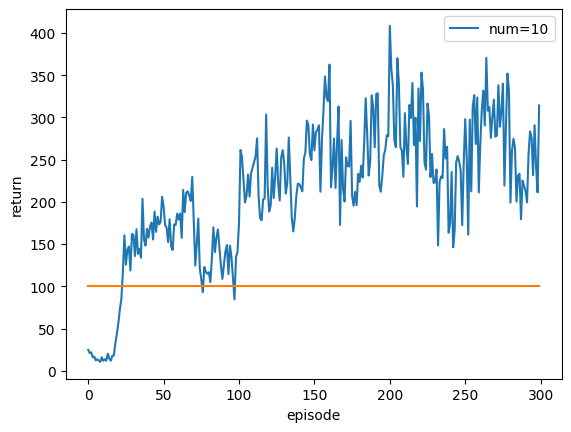

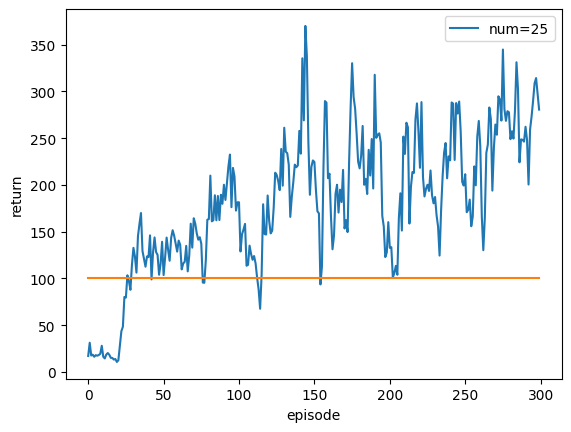

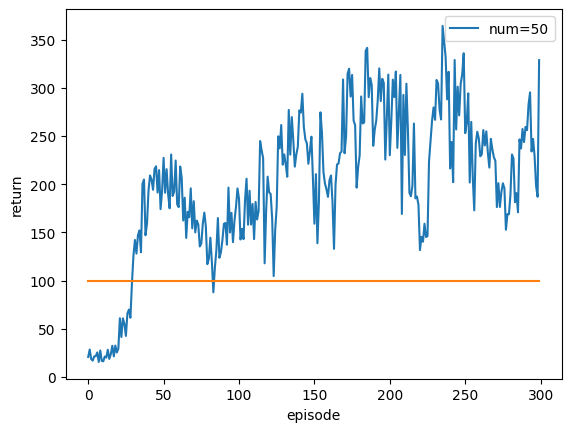

10

In [9]:
legends = []
max_val = -float("inf")
best_num = None
for idx, num in enumerate(nums_results):
    results = torch.tensor(num)
    means = results.float().mean(0)
    if torch.mean(means[150:]) > max_val:
        max_val = torch.mean(means[150:])
        best_num = nums[idx]
    legend = f"num={nums[idx]}"
    legends.append(legend)
    plt.plot(torch.arange(300), means)
    constant = [100] * 300
    plt.plot(torch.arange(300), constant)


    plt.legend(legends)
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.show()
    legends = []
best_num

Change test_model function to tune epsilon, now a combination of linear decrease and convergence

In [25]:
def test_model_combination(episodes_num, runs_num, architecture, learning_rate, memory_size, batch_size, num, update_net_freq):


    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(runs_num):
        print(f"Starting run {run+1} of {runs_num}")
        policy_net = DQN(architecture)
        target_net = DQN(architecture)
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
        memory = ReplayBuffer(memory_size)

        steps_done = 0

        episode_durations = []
        epsilon = 1 + (0.9 / num)
        for i_episode in range(episodes_num):
            if i_episode >= num:
                epsilon *= 0.98
            else:
                epsilon -= (0.9 / num)
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", episodes_num)

            observation, info = env.reset()
            state = torch.tensor(observation).float()


            done = False
            terminated = False
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_net_freq == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results

In [26]:
nums_2= [5, 10, 25, 50, 100, 150]


#SAVE THIS VARIABLE USING PICKLE
nums_2_results = []

for idx, num in enumerate(nums_2):
    nums_2_results.append(test_model_combination(episodes_num=300, runs_num=2, architecture=best_architecture, learning_rate=0.01, memory_size=10000, batch_size=100, num=num, update_net_freq=1))

Starting run 1 of 2


c:\Users\Kotsi\Desktop\AI_Imperial\RL\CW_2\my_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 2
episode  50 / 300
episode  100 / 300
episo

In [27]:
import pickle

file_name = "combination_epsilon.pkl"

variables = {"combination_epsilon" : nums_2_results}

with open(file_name, "wb") as file:
    pickle.dump(variables, file)

In [10]:
import pickle 

file_name = "combination_epsilon_8runs.pkl"

with open(file_name, "rb") as file:
    loaded_variables = pickle.load(file)

nums_2_results = loaded_variables["combination_epsilon_8runs"]
nums_2= [5, 10, 25, 50, 100, 150]

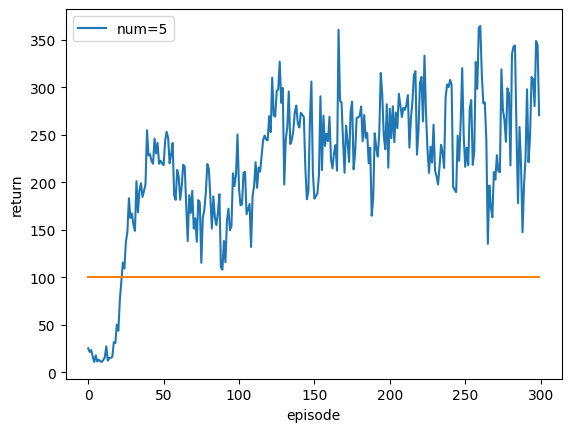

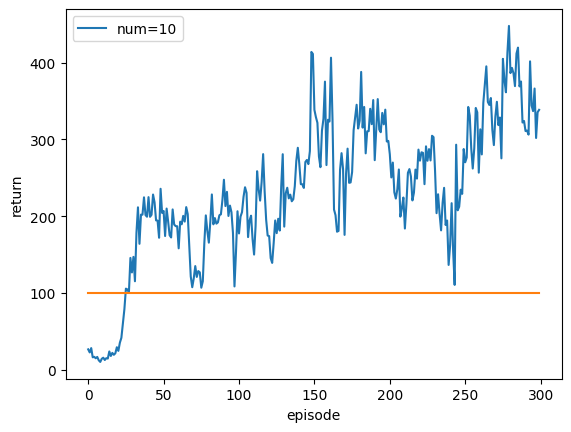

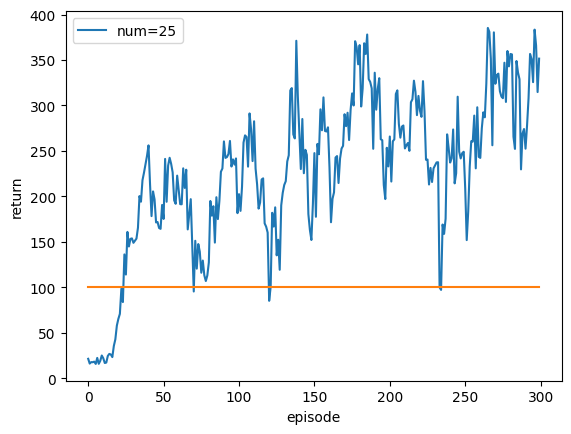

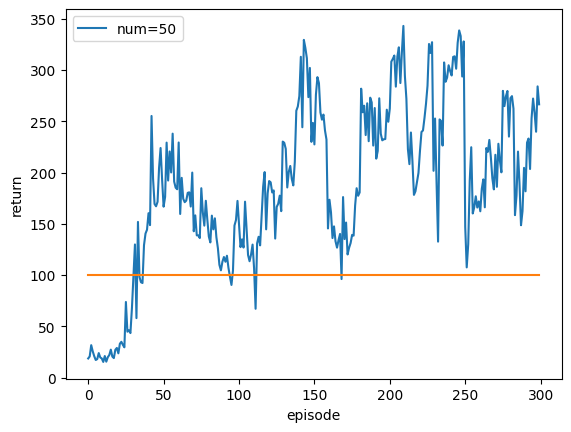

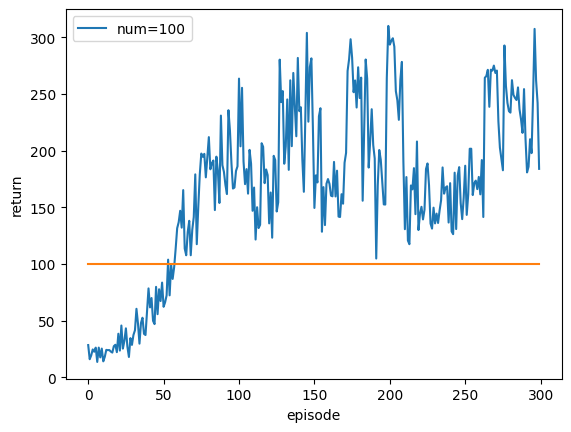

10

In [11]:
legends = []
max_val = -float("inf")
best_num = None
for idx, num in enumerate(nums_2_results):
    results = torch.tensor(num)
    means = results.float().mean(0)
    if torch.mean(means[150:]) > max_val:
        max_val = torch.mean(means[150:])
        best_num = nums_2[idx]
    legend = f"num={nums_2[idx]}"
    legends.append(legend)
    plt.plot(torch.arange(300), means)
    constant = [100] * 300
    plt.plot(torch.arange(300), constant)


    plt.legend(legends)
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.show()
    legends = []
best_num

Change test_model function to tune epsilon, now only converging epsilon

In [30]:
def test_model_decay(episodes_num, runs_num, architecture, learning_rate, memory_size, batch_size, rate, update_net_freq):


    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(runs_num):
        print(f"Starting run {run+1} of {runs_num}")
        policy_net = DQN(architecture)
        target_net = DQN(architecture)
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
        memory = ReplayBuffer(memory_size)

        steps_done = 0

        episode_durations = []
        epsilon = 1 
        for i_episode in range(episodes_num):
            epsilon *= rate
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", episodes_num)

            observation, info = env.reset()
            state = torch.tensor(observation).float()


            done = False
            terminated = False
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_net_freq == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results

In [31]:
rates= [0.999, 0.99, 0.98, 0.95, 0.9]

#SAVE THIS VARIABLE USING PICKLE
rates_results = []

for idx, rate in enumerate(rates):
    rates_results.append(test_model_decay(episodes_num=300, runs_num=2, architecture=best_architecture, learning_rate=0.01, memory_size=10000, batch_size=100, rate=rate, update_net_freq=1))

Starting run 1 of 2


c:\Users\Kotsi\Desktop\AI_Imperial\RL\CW_2\my_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 2
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 2
episode  50 / 300
episode  100 / 300
episo

In [32]:
import pickle

file_name = "decay_epsilon.pkl"

variables = {"decay_epsilon" : rates_results}

with open(file_name, "wb") as file:
    pickle.dump(variables, file)

In [12]:
import pickle 

file_name = "decay_epsilon_8runs.pkl"

with open(file_name, "rb") as file:
    loaded_variables = pickle.load(file)

rates_results = loaded_variables["decay_epsilon_8runs"]
rates= [0.999, 0.99, 0.98, 0.95, 0.9]


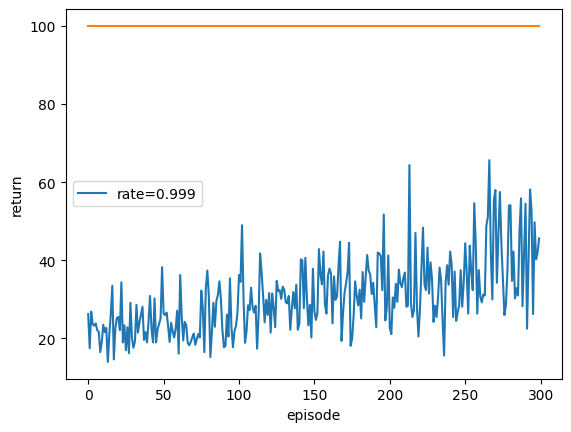

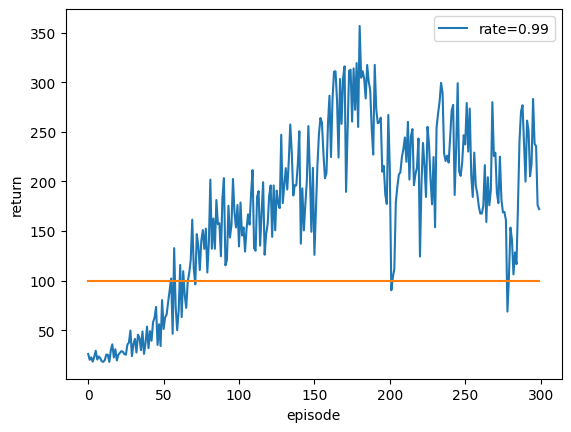

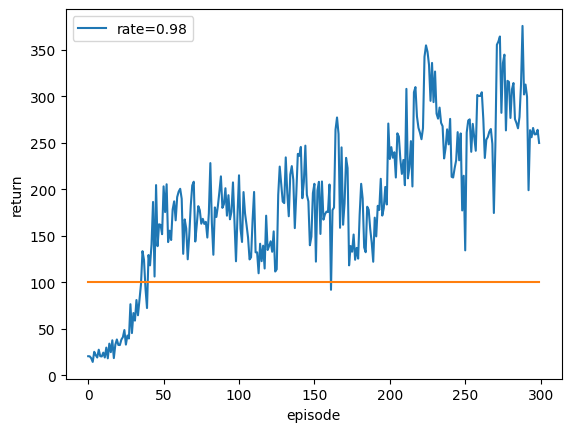

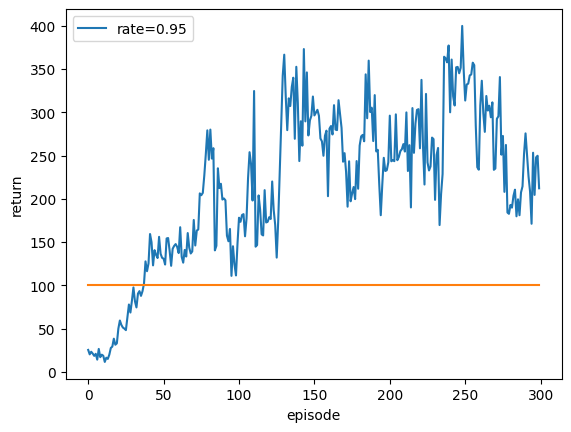

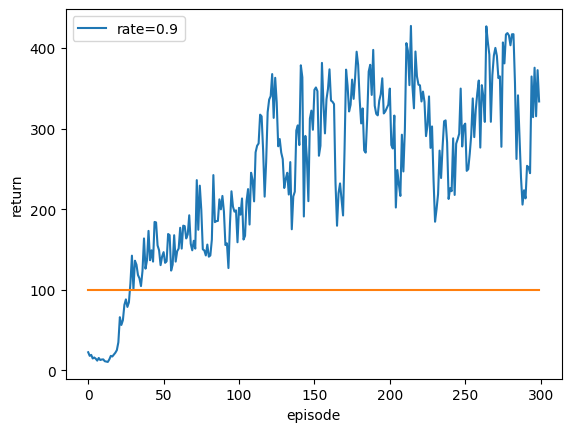

0.9

In [13]:
legends = []
max_val = -float("inf")
best_rate = None
for idx, rate in enumerate(rates_results):
    results = torch.tensor(rate)
    means = results.float().mean(0)
    if torch.mean(means[150:]) > max_val:
        max_val = torch.mean(means[150:])
        best_rate = rates[idx]
    legend = f"rate={rates[idx]}"
    legends.append(legend)
    plt.plot(torch.arange(300), means)
    constant = [100] * 300
    plt.plot(torch.arange(300), constant)


    plt.legend(legends)
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.show()
    legends = []
best_rate

Some final experiments for epsilon

In [7]:
def test_model_creative(episodes_num, runs_num, architecture, learning_rate, memory_size, batch_size, stages, update_net_freq):


    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(runs_num):
        print(f"Starting run {run+1} of {runs_num}")
        policy_net = DQN(architecture)
        target_net = DQN(architecture)
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
        memory = ReplayBuffer(memory_size)

        steps_done = 0

        episode_durations = []
        epsilon = 0.4 
        for i_episode in range(episodes_num):
            if i_episode >= stages[-1]:
                epsilon *= 0.99
            elif i_episode >= stages[-2]:
                epsilon = 0.1
            elif i_episode >= stages[-3]:
                epsilon = 0.2
            
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", episodes_num)

            observation, info = env.reset()
            state = torch.tensor(observation).float()


            done = False
            terminated = False
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_net_freq == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results

In [5]:
different_stages = [[75, 150, 250], [50, 100, 250], [50,100, 200]]

creative_results = []

for idx, stage in enumerate(different_stages):
    creative_results.append(test_model_creative(episodes_num=300, runs_num=8, architecture=best_architecture, learning_rate=0.01, memory_size=10000, batch_size=100, stages=stage, update_net_freq=1))


Starting run 1 of 8


c:\Users\Kotsi\Desktop\AI_Imperial\RL\CW_2\my_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 8
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 8
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 8
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 8
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 8
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 8
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 8
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 

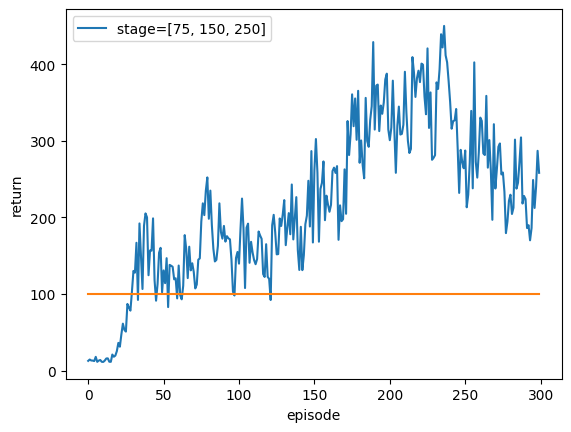

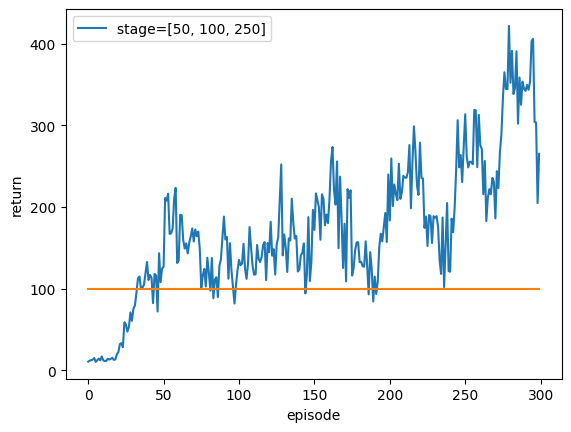

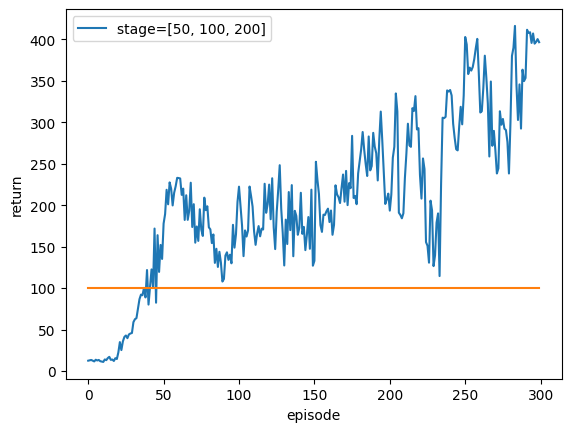

[75, 150, 250]

In [6]:
legends = []
max_val = -float("inf")
best_stage = None
for idx, stage in enumerate(creative_results):
    results = torch.tensor(stage)
    means = results.float().mean(0)
    if torch.mean(means[150:]) > max_val:
        max_val = torch.mean(means[150:])
        best_stage = different_stages[idx]
    legend = f"stage={different_stages[idx]}"
    legends.append(legend)
    plt.plot(torch.arange(300), means)
    constant = [100] * 300
    plt.plot(torch.arange(300), constant)


    plt.legend(legends)
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.show()
    legends = []
best_stage

In [31]:
def test_model_creative_2(episodes_num, runs_num, architecture, learning_rate, memory_size, batch_size, update_net_freq):


    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(runs_num):
        print(f"Starting run {run+1} of {runs_num}")
        policy_net = DQN(architecture)
        target_net = DQN(architecture)
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
        memory = ReplayBuffer(memory_size)

        steps_done = 0

        episode_durations = []
        epsilon = 1
        for i_episode in range(episodes_num):
            epsilon *= 0.90
            
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", episodes_num)

            observation, info = env.reset()
            state = torch.tensor(observation).float()


            done = False
            terminated = False
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_net_freq == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results

In [ ]:
creative_2_results = []


creative_2_results.append(test_model_creative_2(episodes_num=300, runs_num=10, architecture=best_architecture, learning_rate=0.01, memory_size=10000, batch_size=100, update_net_freq=1))

Starting run 1 of 10


c:\Users\Kotsi\Desktop\AI_Imperial\RL\CW_2\my_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episod

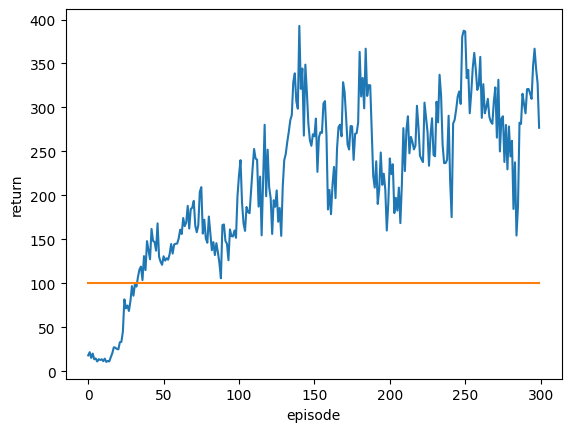

In [19]:
for idx, stage in enumerate(creative_2_results):
    results = torch.tensor(stage)
    means = results.float().mean(0)
    plt.plot(torch.arange(300), means)
    constant = [100] * 300
    plt.plot(torch.arange(300), constant)


    plt.ylabel("return")
    plt.xlabel("episode")
    plt.show()


In [6]:
results = []

results.append(test_model(episodes_num=300, runs_num=10, architecture=best_architecture, learning_rate=0.01, memory_size=10000, batch_size=100, epsilon=1.09, update_net_freq=1))

Starting run 1 of 10


/homes/km2120/Desktop/CW2_RL/cw2-rl/my_venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episod

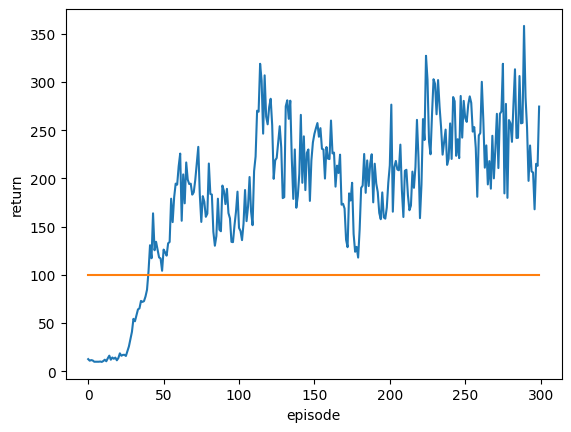

In [7]:
for idx, stage in enumerate(results):
    results_ = torch.tensor(stage)
    means = results_.float().mean(0)
    plt.plot(torch.arange(300), means)
    constant = [100] * 300
    plt.plot(torch.arange(300), constant)


    plt.ylabel("return")
    plt.xlabel("episode")
    plt.show()


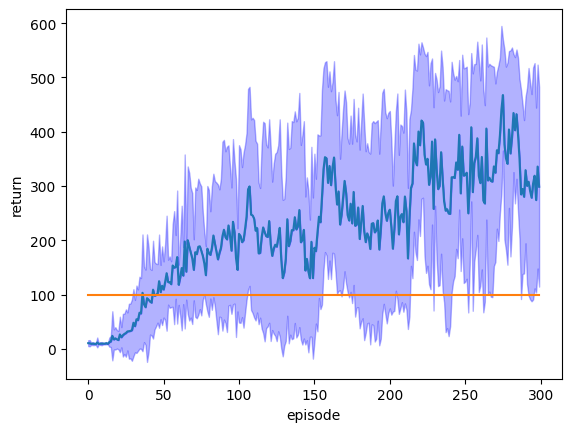

In [84]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results = torch.tensor(epsilon_results[0])
means = results.float().mean(0)
stds = results.float().std(0)
constant = [100] * 300
plt.plot(torch.arange(300), means)
plt.plot(torch.arange(300), constant)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()

Find optimal network update freequency

In [22]:
update_frequencies = [2, 5, 10]

update_frequencies_results = []
for idx, freq in enumerate(update_frequencies):
    update_frequencies_results.append(test_model_creative_2(episodes_num=300, runs_num=10, architecture=best_architecture, learning_rate=0.01, memory_size=10000, batch_size=100, update_net_freq=freq))

Starting run 1 of 10


c:\Users\Kotsi\Desktop\AI_Imperial\RL\CW_2\my_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episod

In [23]:
import pickle

file_name = "update_freq_results.pkl"

variables = {"update_freq_results" : update_frequencies_results}

with open(file_name, "wb") as file:
    pickle.dump(variables, file)

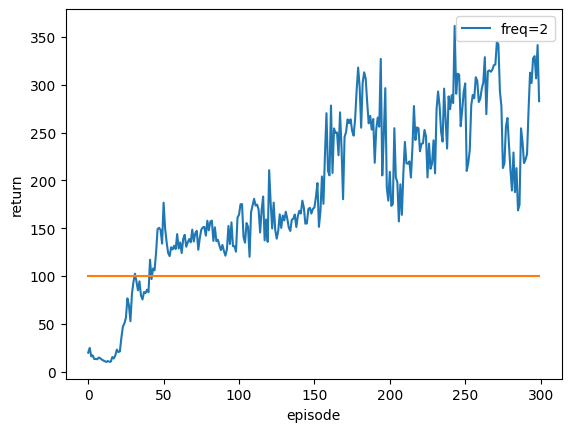

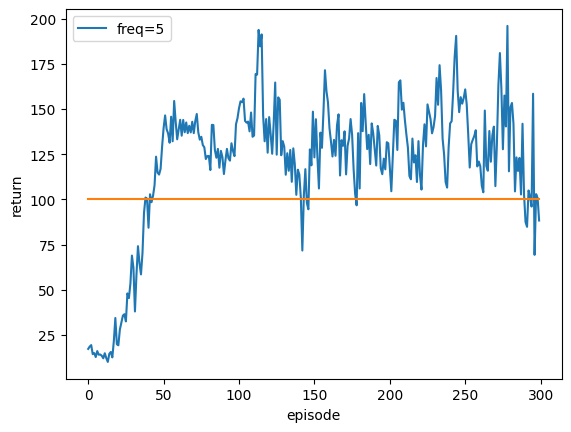

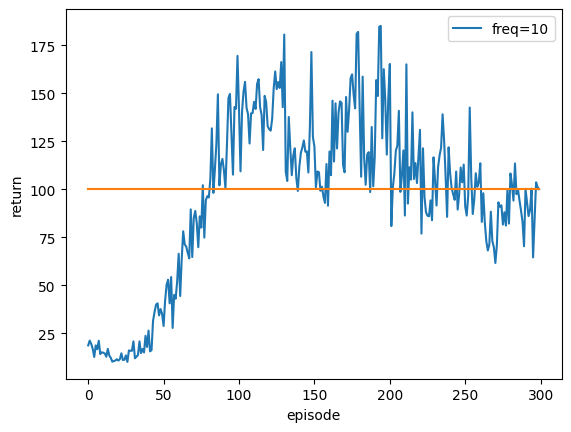

10

In [24]:
legends = []
min_val = float("inf")
best_freq = None
for idx, freq in enumerate(update_frequencies_results):
    results = torch.tensor(freq)
    means = results.float().mean(0)
    stds = results.float().std(0)
    if torch.mean(stds[150:]) < min_val:
        min_val = torch.mean(stds[150:])
        best_freq = update_frequencies[idx]
    legend = f"freq={update_frequencies[idx]}"
    legends.append(legend)
    
    constant = [100] * 300
    plt.plot(torch.arange(300), means)
    plt.plot(torch.arange(300), constant)

    plt.legend(legends)
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.show()
    legends=[]
best_freq

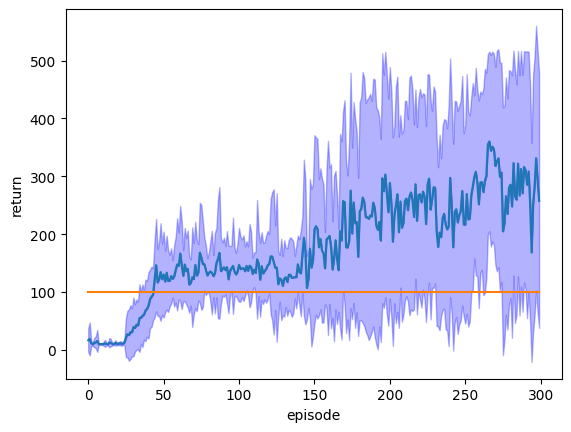

In [13]:
results = torch.tensor(update_frequencies_results[1])
means = results.float().mean(0)
stds = results.float().std(0)
constant = [100] * 300
plt.plot(torch.arange(300), means)
plt.plot(torch.arange(300), constant)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()

Tune the learning rate parameter

In [10]:
learning_rates = [0.05, 0.005, 0.001, 0.0005]

learning_rates_results = []
for idx, learning_rate in enumerate(learning_rates):
    learning_rates_results.append(test_model_creative_2(episodes_num=300, runs_num=10, architecture=best_architecture, learning_rate=learning_rate, memory_size=10000, batch_size=100, update_net_freq=1))

Starting run 1 of 10


/homes/km2120/Desktop/CW2_RL/cw2-rl/my_venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episod

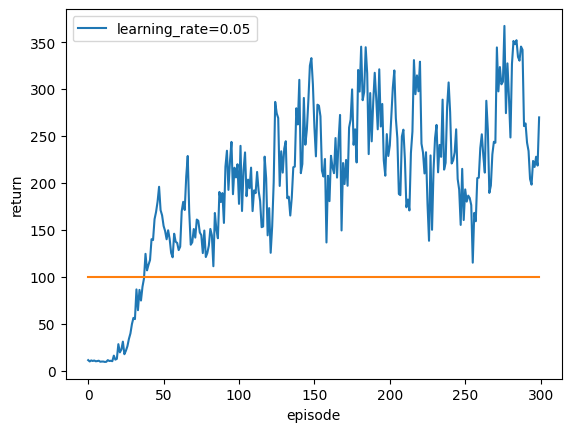

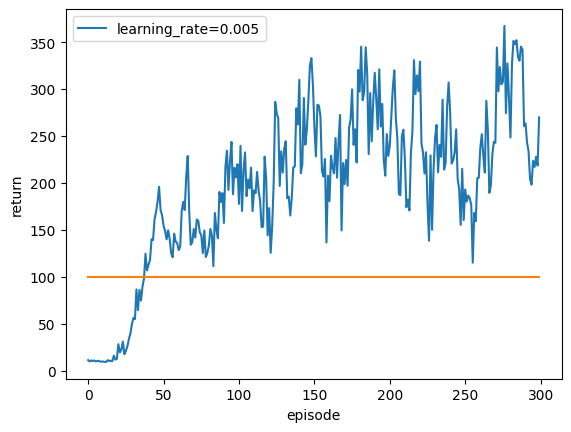

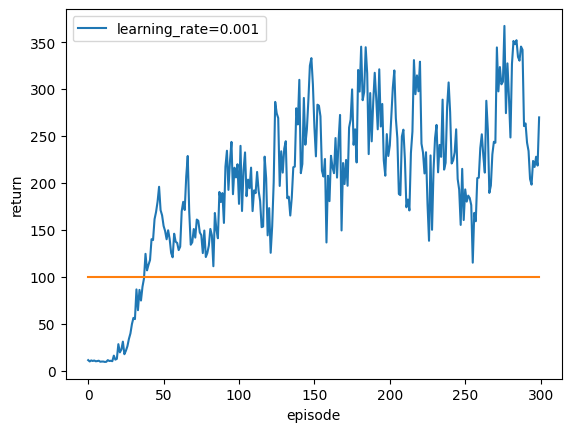

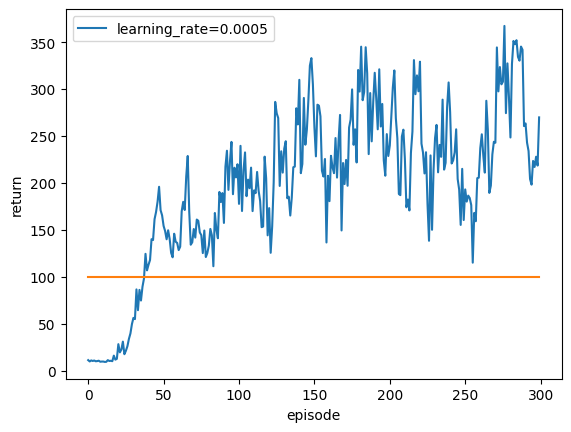

0.05

In [12]:
legends = []
max_val = -float("inf")
best_learning_rate = None
for idx, learning_rate in enumerate(learning_rates_results):
    results = torch.tensor(stage)
    means = results.float().mean(0)
    if torch.mean(means[150:]) > max_val:
        max_val = torch.mean(means[150:])
        best_learning_rate = learning_rates[idx]
    legend = f"learning_rate={learning_rates[idx]}"
    legends.append(legend)
    plt.plot(torch.arange(300), means)
    constant = [100] * 300
    plt.plot(torch.arange(300), constant)


    plt.legend(legends)
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.show()
    legends = []
best_learning_rate

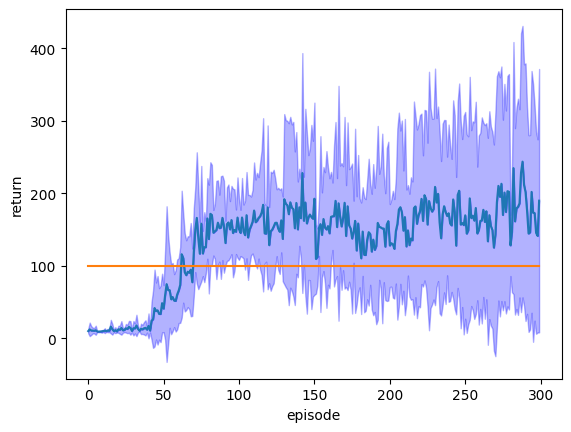

In [14]:
results = torch.tensor(update_frequencies_results[-1])
means = results.float().mean(0)
stds = results.float().std(0)
constant = [100] * 300
plt.plot(torch.arange(300), means)
plt.plot(torch.arange(300), constant)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()

We recreate the test_model function and we converge epsilon

In [96]:
epsilons= [1.09]


#SAVE THIS VARIABLE USING PICKLE
epsilon_2_results = []

for idx, epsilon in enumerate(epsilons):
    epsilon_2_results.append(test_model(episodes_num=300, runs_num=10, architecture=best_architecture, learning_rate=0.01, memory_size=5000, batch_size=50, epsilon=epsilon, update_net_freq=1))

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

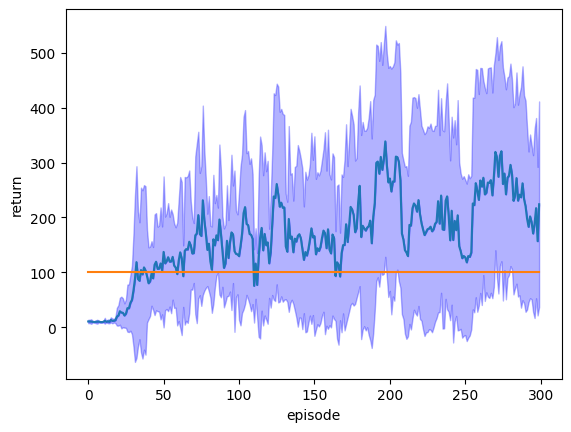

In [97]:
results = torch.tensor(epsilon_2_results[0])
means = results.float().mean(0)
stds = results.float().std(0)
constant = [100] * 300
plt.plot(torch.arange(300), means)
plt.plot(torch.arange(300), constant)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()

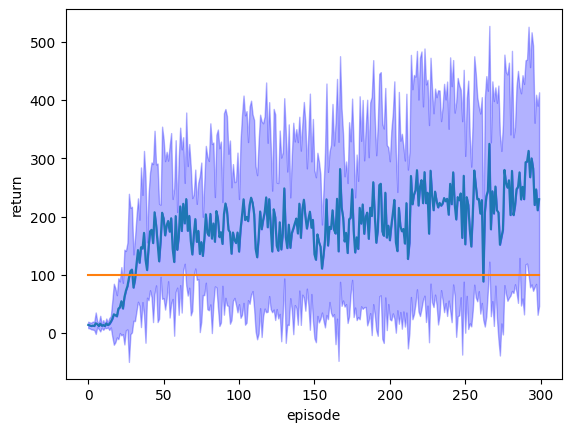

In [14]:
results = torch.tensor(best_memory_batch_size_results)
means = results.float().mean(0)
stds = results.float().std(0)
constant = [100] * 300
plt.plot(torch.arange(300), means)
plt.plot(torch.arange(300), constant)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()

Final Model

In [32]:
final_results = test_model_creative_2(episodes_num=300, runs_num=10, architecture=best_architecture, learning_rate=0.01, memory_size=10000, batch_size=100, update_net_freq=1)

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

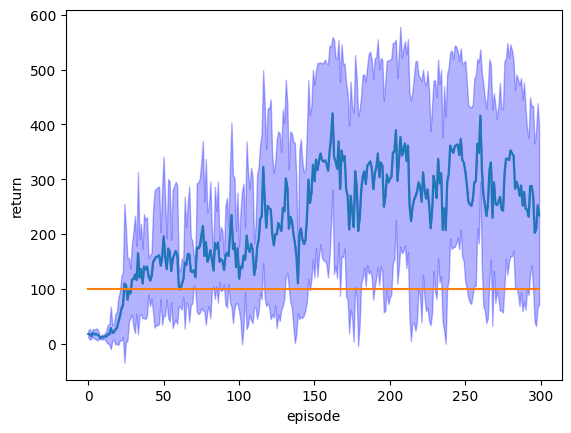

In [33]:
results = torch.tensor(final_results)
means = results.float().mean(0)
stds = results.float().std(0)
constant = [100] * 300
plt.plot(torch.arange(300), means)
plt.plot(torch.arange(300), constant)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()

In [34]:
import pickle

file_name = "final_results.pkl"

variables = {"final_results" : final_results}

with open(file_name, "wb") as file:
    pickle.dump(variables, file)

In [ ]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0., angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()